# **Riiid! Answer Correctness Prediction V3**

## Imports

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import time


from collections import defaultdict
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from lightgbm import LGBMClassifier
from sklearn import pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

## GLOBAL PARAMETERS

In [2]:
IS_TIMESTAMPS_IN_MONTH = True

IS_TIMESTAMPS_IN_DAY = False

IS_PRIOR_TIME_IN_HOUR = True

IS_FIRST_QUESTION = True

IS_TEST = True

IS_EVAL = False

nbmillisec_in_hour = 1000 * 60 * 60

## Functions

In [3]:
def distribution_nb_apparition_tag_questions(nb_tags, title, with_return):
    tags_most_common = tags_frequence.most_common(nb_tags)
    tags_df = pd.DataFrame(tags_most_common, columns = ['tags' , 'nb_tags']) 
    tags_df.columns
    tags_sorted_df = tags_df.sort_values(['nb_tags'], ascending=False)
    tags_counts = tags_sorted_df['nb_tags'].values
    plt.plot(tags_counts)
    plt.title(title)
    plt.grid()
    plt.xlabel("Nombre de tags")
    plt.ylabel("Nombre d'occurences")
    plt.show()
    if(with_return):
        return tags_df
    

def tags_column_processing(tags):
    new_tags = []
    tags_words = tags.split()
    for tag in tags_words:
        if (tag in SELECTED_TAGS) :
            new_tags.append(tag)   
    return new_tags

In [4]:
def preprocessing_data(data_df):
    # We keep only question interations
    data_df = data_df[data_df['content_type_id'] == 0]
    data_df = data_df.drop(['content_type_id'], axis=1)
    
    # prior_question_had_explanation : fill missing values and label encoding
    #data_df['prior_question_had_explanation'].fillna(False, inplace=True)
    data_df['prior_had_explanation_le'] = 0
    data_df.loc[data_df["prior_question_had_explanation"]== True, "prior_had_explanation_le"] = 1
    data_df = data_df.drop(['prior_question_had_explanation'], axis=1)
    
    if(IS_FIRST_QUESTION):
        data_df['is_first_question'] = 0
        data_df.loc[(data_df['prior_question_elapsed_time'].isna()) | (data_df['timestamp'] == 0),\
                    'is_first_question'] = 1
        data_df = data_df.astype({"is_first_question":'int8'}) 
    
    if(IS_TIMESTAMPS_IN_MONTH):
        data_df['timestamp_in_month'] = data_df['timestamp'] / (nbmillisec_in_hour * 24 * 365 / 12)
        data_df = data_df.astype({"timestamp_in_month":'float32'}) 
        
    if(IS_TIMESTAMPS_IN_DAY):
        data_df['timestamp_in_day'] = data_df['timestamp'] / (nbmillisec_in_hour * 24)
        data_df = data_df.astype({"timestamp_in_day":'float32'}) 
    
    prior_question_elapsed_time_mean = data_df[~data_df['prior_question_elapsed_time'].\
                                               isna()]['prior_question_elapsed_time'].mean()
    data_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    
    
    if(IS_PRIOR_TIME_IN_HOUR):
        data_df['prior_time_in_hours'] = data_df['prior_question_elapsed_time'] / nbmillisec_in_hour
        data_df = data_df.astype({"prior_time_in_hours":'float32'}) 

    return data_df

## Data loading

We will follow this tutorials : [Competition API Detailed Introduction](https://www.kaggle.com/sohier/competition-api-detailed-introduction) and 
[Tutorial on reading large datasets](http://https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/).

In [5]:
%%time

questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 18.6 ms, sys: 4.56 ms, total: 23.1 ms
Wall time: 30.5 ms


In [6]:
%%time

dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', 
                       low_memory=False, 
                       nrows=10**6, 
                       dtype=dtypes
                      )
print("Train size:", train_df.shape)

Train size: (1000000, 10)
CPU times: user 2.85 s, sys: 312 ms, total: 3.17 s
Wall time: 3.26 s


In [7]:
print(train_df.shape)
train_df = preprocessing_data(train_df)
print(train_df.shape)

(1000000, 10)
(980093, 12)


In [8]:
train_df.memory_usage(deep=True)

Index                          7840744
row_id                         7840744
timestamp                      7840744
user_id                        3920372
content_id                     1960186
task_container_id              1960186
user_answer                     980093
answered_correctly              980093
prior_question_elapsed_time    3920372
prior_had_explanation_le       7840744
is_first_question               980093
timestamp_in_month             3920372
prior_time_in_hours            3920372
dtype: int64

## We keep 2 years (cf EDA)

In [9]:
train_df = train_df[train_df['timestamp'] <= (2 * 365 * 24 * 60 *60 *1000)]

## questions.csv

In [10]:
questions_df['tags'].fillna("", inplace=True)
questions_df["nb_tags"] = questions_df["tags"].apply(lambda text: len(text.split()))

In [11]:
questions_df = questions_df[questions_df["nb_tags"] > 0]

In [12]:
questions_df['tags_list'] = questions_df['tags'].apply(lambda x: x.split())
tags_list = [item for sublist in questions_df['tags_list'].values for item in sublist]
print(len(tags_list))
tags_unique_list = list(set(tags_list))
# Affiche la nouvelle liste 
print(len(tags_unique_list))

30992
188


In [13]:
tags_frequence= nltk.FreqDist(tags_list)
NB_TAGS = 25
words_most_common = tags_frequence.most_common(NB_TAGS)
fq_words_df = pd.DataFrame(words_most_common, columns = ['tags' , 'nb_tags'])

SELECTED_TAGS = (fq_words_df['tags'][:NB_TAGS]).to_list()
#print(SELECTED_TAGS)
questions_df['new_tags'] = questions_df["tags"].apply(lambda text : tags_column_processing(text))
classes_tags = tuple(SELECTED_TAGS)
one_hot = MultiLabelBinarizer(classes = classes_tags )

types_encoded = pd.DataFrame(one_hot.fit_transform(questions_df['new_tags']),columns=one_hot.classes_)
#types_encoded.head()
questions_df = pd.concat([questions_df,types_encoded], axis = 1)
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,nb_tags,tags_list,new_tags,92,38,...,106,1,96,12,97,67,55,27,122,79
0,0.0,0.0,0.0,1.0,51 131 162 38,4.0,"[51, 131, 162, 38]","[131, 162, 38]",0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,131 36 81,3.0,"[131, 36, 81]","[131, 81]",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,0.0,1.0,131 101 162 92,4.0,"[131, 101, 162, 92]","[131, 162, 92]",1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.0,0.0,1.0,131 149 162 29,4.0,"[131, 149, 162, 29]","[131, 162, 29]",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.0,3.0,1.0,131 5 162 38,4.0,"[131, 5, 162, 38]","[131, 162, 38]",0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Drop column B as it is now encoded
questions_df = questions_df.drop(['new_tags', 'tags', 'tags_list'],axis = 1)

In [15]:
questions_df = questions_df[~questions_df['part'].isna()]

In [16]:
questions_df['is_reading_section']= 0 
questions_df.loc[questions_df['part'] >= 5 ,'is_reading_section'] = 1

## Merge questions and train

In [17]:
train_df = pd.merge(train_df,questions_df, how='left', left_on='content_id', right_on='question_id').sort_values('row_id')

In [18]:
user_agg = train_df.groupby('user_id')['answered_correctly'].\
                    agg(['sum', 'count'])
train_df['user_count'] = train_df['user_id'].map(user_agg['count']).astype('int32')
train_df['user_nb_mean'] = train_df['user_id'].map(user_agg['sum']/user_agg['count']).astype('int32')

In [19]:
content_agg = train_df.groupby('content_id')['answered_correctly'].\
                        agg(['sum', 'count']) #'mean', 'median', 'std'
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_nb_mean'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

Number of attempts

In [20]:
train_df['nb_attempt'] = train_df.groupby(['user_id', 'content_id']).cumcount()+1

In [21]:
train_df.head(15)

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_had_explanation_le,is_first_question,...,55,27,122,79,is_reading_section,user_count,user_nb_mean,content_count,content_nb_mean,nb_attempt
0,0,0,115,5692,1,3,1,25319.472656,0,1,...,0.0,0.0,0.0,0.0,1,46,0,337,0.721068,1
1,1,56943,115,5716,2,2,1,37000.000000,0,0,...,0.0,0.0,0.0,0.0,1,46,0,241,0.771784,1
2,2,118363,115,128,0,0,1,55000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,181,0.961326,1
3,3,131167,115,7860,3,0,1,19000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,203,0.926108,1
4,4,137965,115,7922,4,1,1,11000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,171,0.959064,1
5,5,157063,115,156,5,2,1,5000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,203,0.940887,1
6,6,176092,115,51,6,0,1,17000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,210,0.938095,1
7,7,194190,115,50,7,3,1,17000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,198,0.878788,1
8,8,212463,115,7896,8,2,1,16000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,212,0.938679,1
9,9,230983,115,7863,9,0,1,16000.000000,0,0,...,0.0,0.0,0.0,0.0,0,46,0,448,0.924107,1


In [22]:
import gc


def get_state():
    # compute user features over all train data
    answered_correctly_user = train_df.groupby('user_id')['answered_correctly'].sum().values
    answered_user = train_df.groupby('user_id')['answered_correctly'].count().values  
    mean_user_accuracy = train_df.groupby('user_id')['answered_correctly'].mean().values
    # fill dictionary with default values
    state = dict()
    for user_id in train_df['user_id'].unique():
        state[user_id] = {}
    total = len(state.keys())

    # add user content attempts
    user_content = train_df.groupby('user_id')['content_id'].apply(np.array).apply(np.sort).apply(np.unique)
    user_attempts = train_df.groupby(['user_id', 'content_id'])['content_id'].count().groupby('user_id').apply(np.array).values
    user_attempts -= 1
    
    for user_id, content_id, nb_attempts in tqdm(zip(state.keys(), user_content, user_attempts),total=total):
        state[user_id]['user_content_attempts'] = dict(zip(content_id, nb_attempts))
        
    del user_content, user_attempts
    gc.collect()
    
    for idx, user_id in enumerate(state.keys()):
        state[user_id]['mean_user_accuracy'] = mean_user_accuracy[idx]
        state[user_id]['answered_correctly_user'] = answered_correctly_user[idx]
        state[user_id]['answered_user'] = answered_user[idx]
    return state

state = get_state()
#print('Example of the state for user 2746, attempt counting starts at 0 as the pandas cumcount function is used to create the attempt feature')
display(state[2746])

{'user_content_attempts': {236: 0,
  294: 0,
  297: 1,
  382: 0,
  404: 0,
  405: 0,
  484: 0,
  531: 0,
  714: 0,
  758: 0,
  775: 1,
  873: 0,
  1014: 0,
  1295: 0,
  5273: 0,
  5976: 0,
  10684: 0},
 'mean_user_accuracy': 0.5789473684210527,
 'answered_correctly_user': 11.0,
 'answered_user': 19}

In [23]:
def get_user_data(state, test_df):
    # updated data
    attempt, mean_user_accuracy, answered_correctly_user, answered_user = [], [], [], []
    
    for idx, (user_id, content_id) in test_df[['user_id', 'content_id']].iterrows():
        # check if user exists
        if user_id in state:
            # check if user already answered the question, if so update it to a maximum of 4
            if content_id in state[user_id]['user_content_attempts']:
                state[user_id]['user_content_attempts'][content_id] = min(4, state[user_id]['user_content_attempts'][content_id] + 1)
            # if user did not answered the question already, set the number of attempts to 0
            else:
                state[user_id]['user_content_attempts'][content_id] = 0
        
        # else create user with default values
        else:
            dict_keys = ['mean_user_accuracy', 'answered_correctly_user', 'answered_user', 'user_content_attempts']
            dict_default_vals = [0.680, 0, 0, dict(zip([content_id],[0]))]
            state[user_id] = dict(zip(dict_keys, dict_default_vals))
            
        # add user data to lists
        attempt.append(state[user_id]['user_content_attempts'][content_id])
        mean_user_accuracy.append(state[user_id]['mean_user_accuracy'])
        answered_correctly_user.append(state[user_id]['answered_correctly_user'])
        answered_user.append(state[user_id]['answered_user'])
    
    return attempt, mean_user_accuracy, answered_correctly_user, answered_user

# updates the user data
def update_user_data(state, features_questions_df, prev_test_df):
    for user_id, content_id, answered_correctly in prev_test_df[['user_id', 'content_id', 'answered_correctly']].values:
        # update user features
        state[user_id]['answered_correctly_user'] += answered_correctly
        state[user_id]['answered_user'] += 1
        state[user_id]['mean_user_accuracy'] = state[user_id]['answered_correctly_user'] / state[user_id]['answered_user']

# Baseline

In [24]:
#sc = MinMaxScaler()
sc = StandardScaler()

In [25]:
train_df = train_df[train_df['answered_correctly']!= -1]
features_bsl = ['prior_had_explanation_le', 'nb_attempt',
                'content_id', 'content_count', 'content_nb_mean',
                'user_nb_mean', 'user_count', 
                'is_reading_section',
                'nb_tags',
                '92', '38', '81', '29', '136',
                '162', '102', '8', '143', '131'
                ]

if(IS_TIMESTAMPS_IN_MONTH):
    features_bsl.append('timestamp_in_month')
if(IS_TIMESTAMPS_IN_DAY):
    features_bsl.append('timestamp_in_day')
if(IS_PRIOR_TIME_IN_HOUR):
    features_bsl.append('prior_time_in_hours')
if(IS_FIRST_QUESTION):
    features_bsl.append('is_first_question')



X = train_df[features_bsl]
X = sc.fit_transform(X)
y = train_df['answered_correctly']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=1)

In [26]:
features_bsl

['prior_had_explanation_le',
 'nb_attempt',
 'content_id',
 'content_count',
 'content_nb_mean',
 'user_nb_mean',
 'user_count',
 'is_reading_section',
 'nb_tags',
 '92',
 '38',
 '81',
 '29',
 '136',
 '162',
 '102',
 '8',
 '143',
 '131',
 'timestamp_in_month',
 'prior_time_in_hours',
 'is_first_question']

## Optimisation of the model (Hyperparameter tuning and crossvalidation)

### To optimize my model, I use : Bayesian Optimization (hyperopt) and stratification.

In [27]:

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 0.9),
    'n_estimators': scope.int(hp.quniform('n_estimators', 25, 300, 25)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.2),
}


def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    num_folds=3
    
    
    #def objective_function(params):
    #    clf = lgb.LGBMClassifier(random_state =1, **params)
    #    score = cross_val_score(clf, X_train, y_train, cv=kf).mean()
    #    return {'loss': -score, 'status': STATUS_OK}
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(random_state =1, **params)
        kf = KFold(n_splits=num_folds, shuffle=True)
        score = cross_val_score(clf, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=1).mean()
        return {'loss': 1-score, 'status': STATUS_OK}
    
    
    
    
    
    
    trials = Trials()
    
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
   
    clf_best = lgb.LGBMClassifier(random_state = 1,
                                  feature_fraction=best_param_values[0],
                                  learning_rate=best_param_values[1],
                                  max_depth=int(best_param_values[2]),
                                  n_estimators=int(best_param_values[3]),
                                  num_leaves=int(best_param_values[4]),
                                  reg_lambda=best_param_values[5]
                                 )
    
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("AUROC : ",roc_auc_score(y_test, clf_best.predict_proba(X_test)[:,1]) )
    print("Parameter combinations evaluated: ", num_eval)
    return trials

IS_EVAL = False
if(IS_EVAL):
    num_eval = 75
    results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)


75/75 [29:45<00:00, 23.81s/trial, best loss: 0.24545802722089016]

##### Results
Score best parameters:  -0.24545802722089016
Best parameters:  {'feature_fraction': 0.7847766875579623, 'learning_rate': 0.20475753529956947, 'max_depth': 8.0, 'n_estimators': 300.0, 'num_leaves': 25.0, 'reg_lambda': 0.08560393035568381}
Test Score:  0.7178898261301032
AUROC :  0.7537312406572992
Parameter combinations evaluated:  75

In [28]:
'''params = {
    #'bagging_fraction': 0.5817242323514327,
    'feature_fraction': 0.6884588361650144,
    #'learning_rate': 0.42887924851375825, 
    'learning_rate': 0.4, 
    'max_depth': 7,
    'min_child_samples': 100, 
    'min_child_weight': 0.01,
    'min_data_in_leaf': 20, 
    'n_estimators': 200,
    'n_job': 4,
    'num_leaves': 42,
    'random_state': 1,
    'reg_alpha': 5, 
    'reg_lambda': 0,
    'subsample': 0.863184719640143
}'''

params = {
    'bagging_fraction': 0.6,
    'feature_fraction': 0.7847766875579623, 
    'learning_rate': 0.45, #0.20475753529956947, 
    'max_depth': 8, 
    'n_estimators': 300,
    'num_leaves': 25,
    'reg_lambda': 0,
    'reg_alpha': 5,
    'random_state': 1,
    'n_job': 4,
    'min_child_samples': 100, 
    'min_child_weight': 0.01,
    'min_data_in_leaf': 15,
    'subsample': 0.75
}

lgbm = LGBMClassifier(**params)

In [29]:
lgbm.fit(train_df[features_bsl], y)

LGBMClassifier(bagging_fraction=0.6, feature_fraction=0.7847766875579623,
               learning_rate=0.45, max_depth=8, min_child_samples=100,
               min_child_weight=0.01, min_data_in_leaf=15, n_estimators=300,
               n_job=4, num_leaves=25, random_state=1, reg_alpha=5,
               reg_lambda=0, subsample=0.75)

In [30]:
from sklearn.metrics import roc_auc_score

if(IS_TEST):
    print(roc_auc_score(y.values, lgbm.predict_proba(train_df[features_bsl])[:,1]))

0.7779677120734912


In [31]:
import eli5
from eli5.sklearn import PermutationImportance
if(IS_EVAL):
    train_df.fillna(train_df.median(), inplace=True)
    perm = PermutationImportance(lgbm, random_state=1).fit(train_df[features_bsl], y)
    eli5.show_weights(perm, feature_names = features_bsl)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


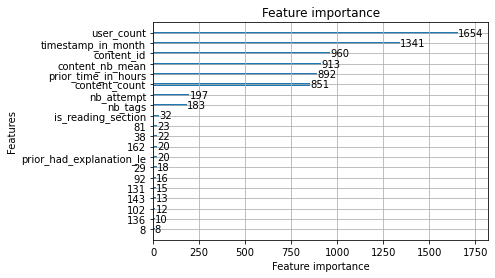

In [32]:
#displaying the most important features
if(IS_TEST):
    lgb.plot_importance(lgbm)
    plt.show()

In [33]:
import riiideducation
import pandas as pd

# You can only call make_env() once, so don't lose it!
env = riiideducation.make_env()

In [34]:
import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [35]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [36]:
prev_test_df = None

iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    if prev_test_df is not None:
        prev_test_df['answered_correctly_01']
        
        for user_id, content_id, answered_correctly in prev_test_df[['user_id', 'content_id', 'answered_correctly_01']].values:
            state[user_id]['answered_correctly_user'] += answered_correctly
            state[user_id]['answered_user'] += 1
            state[user_id]['mean_user_accuracy'] = state[user_id]['answered_correctly_user'] / state[user_id]['answered_user']
        
    test_df = preprocessing_data(test_df)
    
    test_df = pd.merge(test_df,questions_df, how='left', left_on='content_id', right_on='question_id').sort_values('row_id')
    test_df = test_df.sort_values(['user_id','timestamp'], ascending=False)

    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    user_mean = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    content_mean = np.zeros(len(test_df), dtype=np.int16)
    user_content_attempts = np.zeros(len(test_df), dtype=np.int8)
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        
        if user_id not in state:
            dict_keys = ['mean_user_accuracy', 'answered_correctly_user', 'answered_user', 'user_content_attempts']
            dict_default_vals = [0.680, 0, 0, dict(zip([content_id],[0]))]
            state[user_id] = dict(zip(dict_keys, dict_default_vals))
            
        if content_id not in state[user_id]['user_content_attempts']:
            state[user_id]['user_content_attempts'][content_id] = 1
        else:
            state[user_id]['user_content_attempts'][content_id] = state[user_id]['user_content_attempts'][content_id] + 1
        
        #state[user_id]['answered_correctly_user'] += answered_correctly
        #state[user_id]['answered_user'] += 1
        #state[user_id]['mean_user_accuracy'] = state[user_id]['answered_correctly_user'] / state[user_id]['answered_user']
        
        user_content_attempts[i]= state[user_id]['user_content_attempts'][content_id]
        
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        user_mean[i] = state[user_id]['mean_user_accuracy']
        
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        if(content_count[i] > 0 ) :
            content_mean[i] = content_sum[i] / content_count[i]
        else :
            content_mean[i] = 0.65
    test_df['nb_attempt'] = user_content_attempts
    
    test_df['user_count'] = user_count
    test_df['user_sum'] = user_sum
    test_df['user_nb_mean'] = user_mean
    
    test_df['content_count'] = content_count
    test_df['content_nb_mean'] = content_sum/content_count
    test_df['answered_correctly_01'] =  lgbm.predict(test_df[features_bsl])
    test_df['answered_correctly'] =  lgbm.predict_proba(test_df[features_bsl])[:,1]
    env.predict(test_df[['row_id', 'answered_correctly']])
    prev_test_df = test_df.copy()

In [37]:
submission = pd.read_csv('./submission.csv')

In [38]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   row_id              104 non-null    int64  
 1   answered_correctly  104 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 1.8 KB


In [39]:
submission.head()

,row_id,answered_correctly
0,17,0.567705
1,4,0.378941
2,2,0.677744
3,8,0.364633
4,6,0.563906
